# Customer Data Cleaning and Exploratory Data Analysis

This Jupyter notebook focuses on cleaning and performing exploratory data analysis on a customer dataset. The goal is to understand the data's structure, check its quality, and uncover initial insights. The process includes installing necessary libraries and packages, data cleaning, data visualization and feature engineering.

### 0: Install Libraries and Packages

In [1]:

# Core
import numpy as np
import pandas as pd 
import plotly.express as px

# Graphing 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Dates
from datetime import datetime

## 1: Load Data 
Using a dataset simulating customer data from a grocery store rewards program.
Kaggle https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign
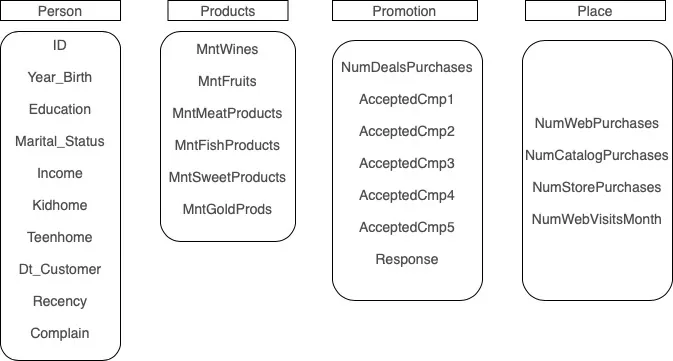

In [2]:
# Load raw data
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2: Data Pre-Processing
2.1 Look for and handle any 
- duplicates
- missing values

2.2 
- remove un-needed columns
- replace any column names for consistency
- Change categorical columns to label encoding or one-hot-encoding

In [3]:
# 2.1 Data Cleaning
print(f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns.")
print(f"Data has {data.duplicated().sum()} duplicates and {data.isnull().sum().sum()} missing values.")

Dataset has 2240 rows and 29 columns.
Data has 0 duplicates and 24 missing values.


In [4]:
print(f"Column(s) with missing data values: {data.columns[data.isnull().any()][0]}")

Column(s) with missing data values: Income


Since only one column (Income) has null values and there are only 1% of rows with the null entries, I will drop the rows from our dataset.

In [5]:
# Dropping duplicates (just in case) and null values 
data.drop_duplicates(inplace=True) 
data.dropna(inplace=True)  

2.2 dealing with non-numeric columns

- 2.2a Identify the non-numeric columns
- 2.2b Determine the amount of categories in each categorical column
- 2.2c Clean up the data in the categorical column

In [6]:
# 2.2a Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: ID, Year_Birth, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response
Columns with data type float64: Income
Columns with data type object: Education, Marital_Status, Dt_Customer


In [7]:
# 2.2b Determine the number of categories for each categorical column
object_columns = data.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"Unique values in column {col}: {data[col].nunique()}")

Unique values in column Education: 5
Unique values in column Marital_Status: 8
Unique values in column Dt_Customer: 662


In [8]:
data['Education'].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [9]:
data['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [10]:
# Change entries that are synonymous with single (Alone, Absurd, YOLO) to Single 
data['Marital_Status'] = data['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
# Change entries that are synonymous with "coupled" (Married, Together) to Coupled 
data['Marital_Status'] = data['Marital_Status'].replace(['Together', 'Married'], 'Coupled')
data['Marital_Status'].value_counts()

Marital_Status
Coupled     1430
Single       478
Divorced     232
Widow         76
Name: count, dtype: int64

In [11]:
data['Dt_Customer'].value_counts()

Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: count, Length: 662, dtype: int64

#### 2.2 INSIGHTS
- Since the Education and Marital_Status columns around five different categories, I will encode them numerically via mapping and converted the columns to integer for the machine learning model.
- Dt_Customer represents the date that a customer joined the rewards program. It has a large number of distinct values (662) in Day-Month-Year format. I will convert the column to a datetime object and then perform feature engineering to add a Duration column for each row.
- I also will add a Age column based on the Birth year and the latest date in the dataset.

In [12]:
# convert to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
# To determine how long the customer has been a customer, I need to know the max date in Dt_customer
Max_date = data['Dt_Customer'].max()
data['Duration'] = (Max_date - data['Dt_Customer']).dt.days
# To calculate the age of the customer, I need todays year
data['Age'] = Max_date.year - data['Year_Birth']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

### 3.0 Exploratory Data Analysis 

- 3.1 Review Statistics and Distributions of Numerical Columns
- 3.2 Identify if there are any outliers that need to be dealt with
- 3.3 Perform Use case EDA to understand the dataset better
- 3.4 Determine if there is any strong correlation between entries 

In [13]:
# 3.1 Numerical Statistics of columns
data.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,2216.0,5588.353339,0.0,2814.75,5458.5,8421.75,11191.0,3249.376275
Year_Birth,2216.0,1968.820397,1893.0,1959.0,1970.0,1977.0,1996.0,11.985554
Income,2216.0,52247.251354,1730.0,35303.0,51381.5,68522.0,666666.0,25173.076661
Kidhome,2216.0,0.441787,0.0,0.0,0.0,1.0,2.0,0.536896
Teenhome,2216.0,0.505415,0.0,0.0,0.0,1.0,2.0,0.544181
Dt_Customer,2216,2013-07-10 11:29:27.509025280,2012-07-30 00:00:00,2013-01-16 00:00:00,2013-07-08 12:00:00,2013-12-31 00:00:00,2014-06-29 00:00:00,NaN
Recency,2216.0,49.012635,0.0,24.0,49.0,74.0,99.0,28.948352
MntWines,2216.0,305.091606,0.0,24.0,174.5,505.0,1493.0,337.32792
MntFruits,2216.0,26.356047,0.0,2.0,8.0,33.0,199.0,39.793917
MntMeatProducts,2216.0,166.995939,0.0,16.0,68.0,232.25,1725.0,224.283273


#### 3.1 Insights
 - *Z_CostContact* and *Z_Revenue* are uniform and can be dropped.
 - There is a birth year from the 1800s which doesn't seem correct and may need to be dropped
 - From reviewing the standard deviation of the numeric columns, it looks like the *Income*, *MntWines* and *MntMeatProducts* have a significantly large standard deviation, thus there are probably outliers that need to be handled.
  

In [14]:
data[data['Year_Birth']<1940]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Duration,Age
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,0,0,0,0,1,3,11,0,276,114
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,0,0,0,0,0,3,11,0,43,121
339,1150,1899,PhD,Coupled,83532.0,0,0,2013-09-26,36,755,...,0,1,0,0,0,3,11,0,276,115


In [15]:
# Drop the uniform columns Z_CostContact and Z_Revenue
data.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
# Only have rows where the birth year is 1940 and older
data = data[data['Year_Birth']>=1940]

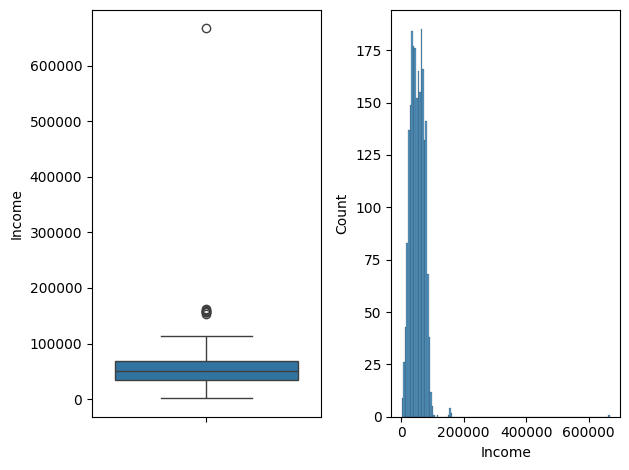

In [16]:
# View the Income data as a row of 2 subplots
fig, axs = plt.subplots(1,2)
# Create boxplot
sns.boxplot(data['Income'], ax=axs[0])
# Create histogram
sns.histplot(data['Income'], ax=axs[1])
plt.tight_layout()
plt.show()

It looks like their is an extreme outlier with an income of over 600,000 and is skewing the distribution. Lets drop that value.

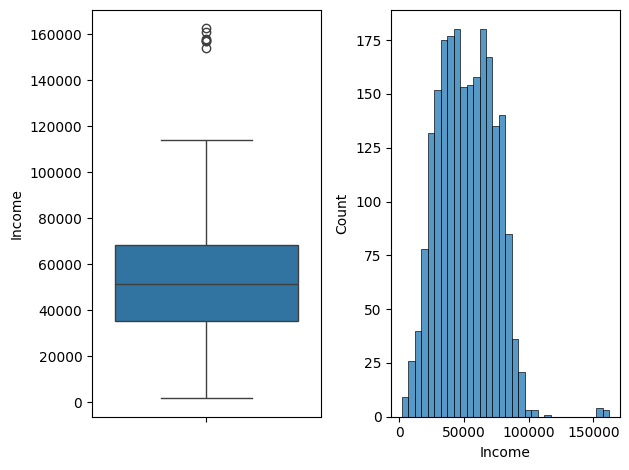

In [17]:
data = data[data['Income'] <= 200000]
# View the Income data as a row of 2 subplots
fig, axs = plt.subplots(1,2)
# Create boxplot
sns.boxplot(data['Income'], ax=axs[0])
# Create histogram
sns.histplot(data['Income'], ax=axs[1])
plt.tight_layout()
plt.show()

Now lets look at *Duration*, *MntWines* and *MntMeatProduct* to see if there are any outliers that are significantly affecting the distribution

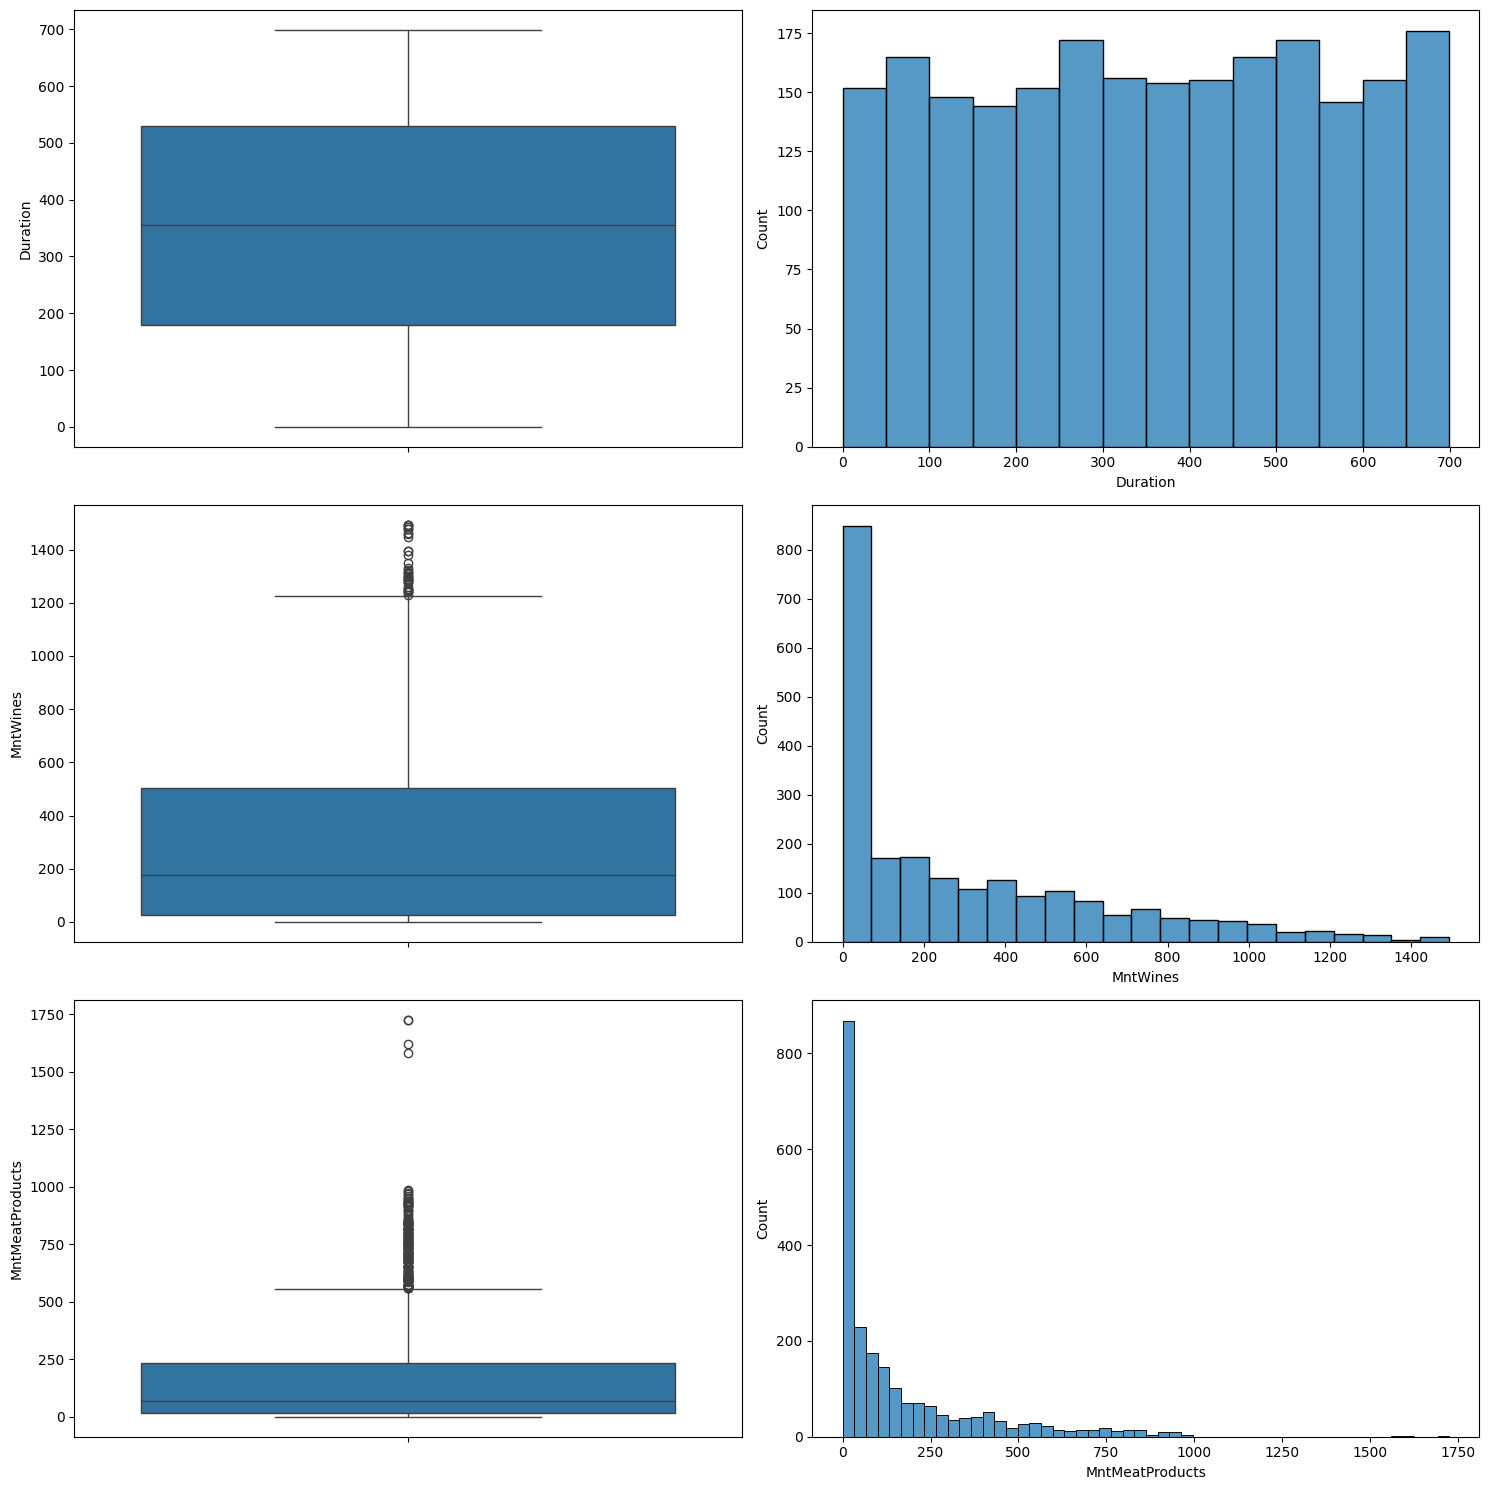

In [37]:
# View the data as 2 rows of 4 subplots
fig, axs = plt.subplots(3,2, figsize=(15,15))
# Create boxplot and histogram for Duration
sns.boxplot(data['Duration'], ax=axs[0,0])
sns.histplot(data['Duration'], ax=axs[0,1])
# Create boxplot and histogram for MntWines
sns.boxplot(data['MntWines'], ax=axs[1,0])
sns.histplot(data['MntWines'], ax=axs[1,1])
# Create boxplot for MntMeat
sns.boxplot(data['MntMeatProducts'], ax=axs[2,0])
# Create histogram
sns.histplot(data['MntMeatProducts'], ax=axs[2,1])
plt.tight_layout()
plt.show()

*Duration* has no outliers and has a uniform distribution, so there is no need to make any changes to it. 
*MntWines* and *MntMeatProducts* are both are right skewed with large outliers. Removing the large outliers will not change the skewness of the data as the modes of both are the minimum values. So I will not remove the outlier data.

#### 3.3 Visual EDA to better understand the demographics throughout campaigns
There were five different marketing campaigns run, how successful were they?
Which campaign(s) did a customer purchase from?

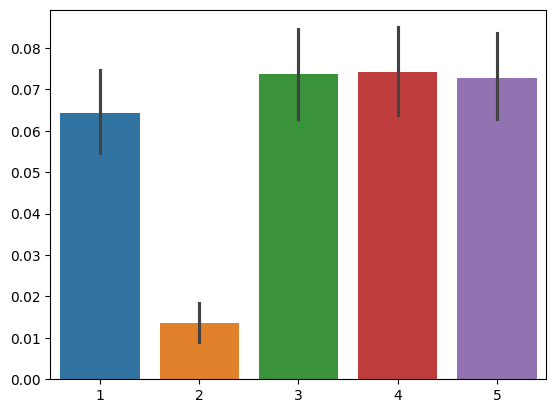

In [19]:
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
sns.barplot(data[campaign_columns])
plt.xticks(range(len(campaign_columns)), range(1,len(campaign_columns)+1))
plt.show()

Total_Campaigns
0    1754
1     322
2      81
3      44
4      11
Name: count, dtype: int64


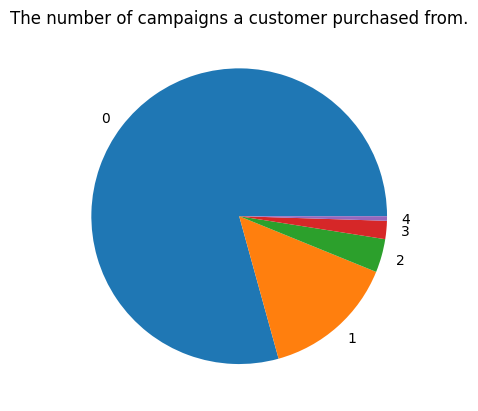

In [20]:
# Calculate the number of campaigns that a customer purchased from
data['Total_Campaigns'] = data[campaign_columns].sum(axis=1)
print(data['Total_Campaigns'].value_counts())
plt.pie(data['Total_Campaigns'].value_counts(), labels=data['Total_Campaigns'].value_counts().index)
plt.title("The number o campaifgns a customer purchased from.")
plt.show()

#### 3.3 Insights
- The majority of the customers did not purchase anything as a result of a campaign
- No more than 8% of the customer dataset accepted offers from a campaign.   
- Campaigns 3, 4 and 5 were similarily productive
- Campaign 2 was the least successful
  
#### 3.4 Customer Details Analysis


In [21]:
# Correlation of the data
numeric_columns = data.select_dtypes(include=['int64','float64']).columns
px.imshow(
    data[numeric_columns].corr(), 
    width=1000,
    height=1000,
    template='plotly_dark',
    title="Customer Insights: Feature Correlations"
)

The correlation matrix doesn't reveal any surprising correlations.

In [22]:
customer_attributes = ['Age','Marital_Status', 'Education', 'Income', 'Total_Campaigns']
data_customer = data[customer_attributes]
print(f"Customer age range: {data_customer['Age'].min()} - {data_customer['Age'].max()}.")
print(f"Customer Income range: ${data_customer['Income'].min()} - ${data_customer['Income'].max()}.")

Customer age range: 18 - 74.
Customer Income range: $1730.0 - $162397.0.


<Axes: ylabel='Income'>

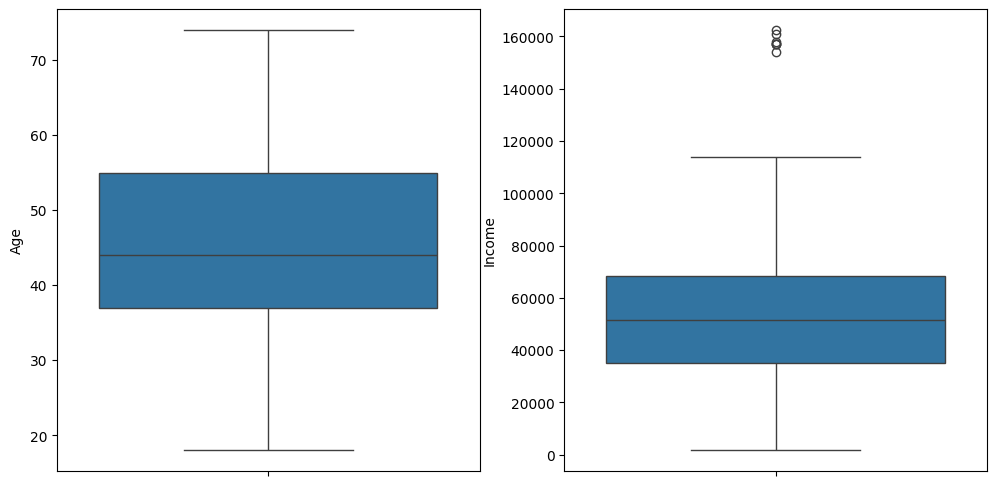

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(data_customer['Age'], ax=axs[0])
sns.boxplot(data_customer['Income'], ax=axs[1])

In [24]:
# Lets break  up the age and income into groups 
# Define the bin edges
age_bins = [28, 40, 55, 70, 85]
income_bins = [0, 30000, 60000, 90000, 200000]

# Bin the data
data_customer['Group_Age'] = np.digitize(data['Age'], bins=age_bins)
data_customer['Group_Income'] = np.digitize(data['Income'], bins=income_bins)

# Map the bin indices to labels
age_labels = {1: '28-40', 2: '41-55', 3: '56-70', 4: '71-85'}
income_labels = {1: '0-30K', 2: '30K-60K', 3: '60K-90K', 4: '90k-180k'}
data_customer['Group_Age'] = data_customer['Group_Age'].map(age_labels)
data_customer['Group_Income'] = data_customer['Group_Income'].map(income_labels)

C:\Users\kymno\AppData\Local\Temp\ipykernel_22260\774773561.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kymno\AppData\Local\Temp\ipykernel_22260\774773561.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kymno\AppData\Local\Temp\ipykernel_22260\774773561.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

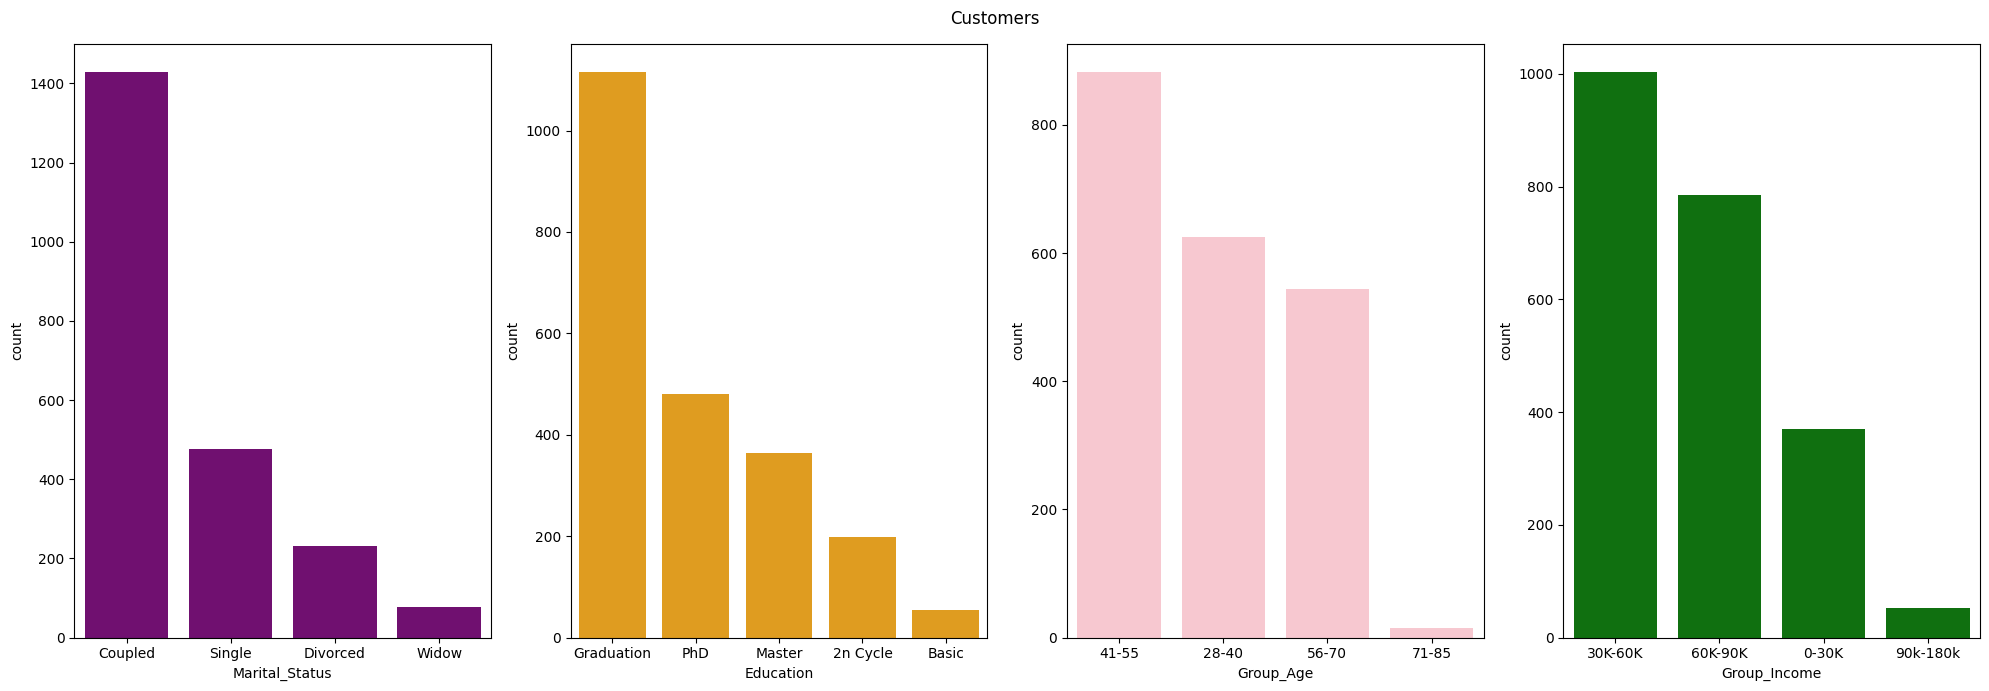

In [25]:
# View the customer breakdown per feature
fig, axs = plt.subplots(1,4, figsize=(20,7))
sns.barplot(data_customer['Marital_Status'].value_counts(), color="purple", ax=axs[0])
sns.barplot(data_customer['Education'].value_counts(), color='orange', ax=axs[1])
sns.barplot(data_customer['Group_Age'].value_counts(), color='pink',ax=axs[2])
sns.barplot(data_customer['Group_Income'].value_counts(), color='green',ax=axs[3])
fig.suptitle("Customers")
plt.tight_layout()
plt.show()

<Axes: xlabel='Group_Age', ylabel='Income'>

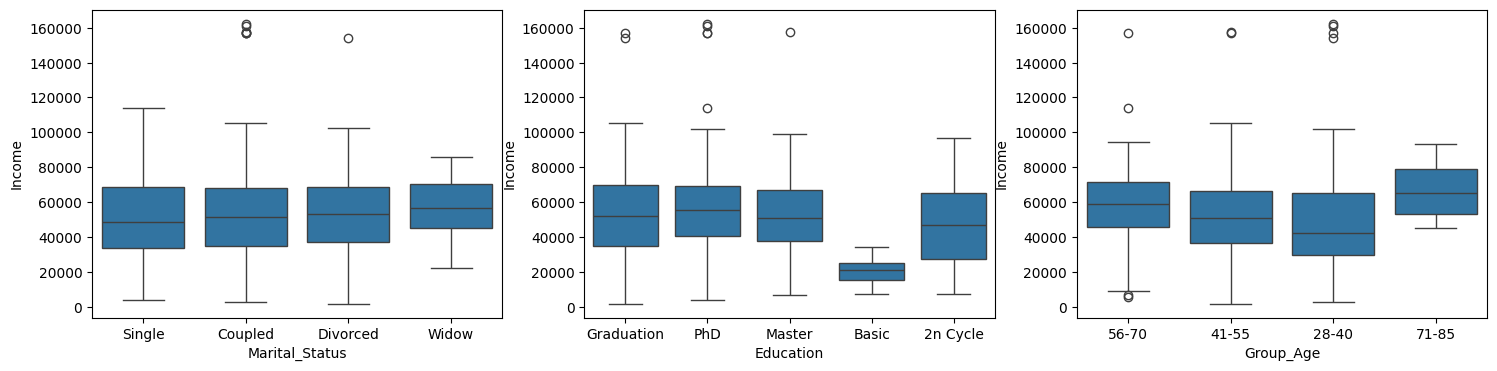

In [26]:
fig, axs = plt.subplots(1,3, figsize=(18,4))
sns.boxplot(data=data_customer, x='Marital_Status', y='Income', ax=axs[0])
sns.boxplot(data=data_customer, x='Education', y='Income', ax=axs[1])
sns.boxplot(data=data_customer, x='Group_Age', y='Income', ax=axs[2])


Text(0.5, 0.98, 'Total Campaigns Purchased from by Customer Attributes')

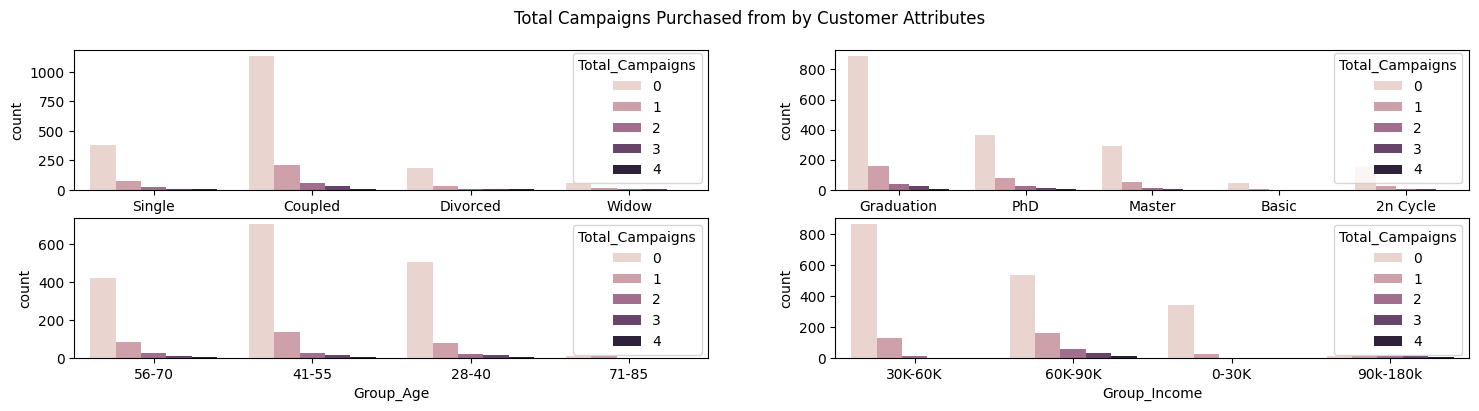

In [27]:
fig, axs = plt.subplots(2,2, figsize=(18,4))
sns.countplot(data=data_customer, x='Marital_Status', hue='Total_Campaigns', ax=axs[0,0])
sns.countplot(data=data_customer, x='Education', hue='Total_Campaigns', ax=axs[0,1])
sns.countplot(data=data_customer, x='Group_Age', hue='Total_Campaigns', ax=axs[1,0])
sns.countplot(data=data_customer, x='Group_Income', hue='Total_Campaigns', ax=axs[1,1])
plt.suptitle("Total Campaigns Purchased from by Customer Attributes")


Text(0.5, 0.98, 'Total Campaigns Purchased from by Customer Attributes')

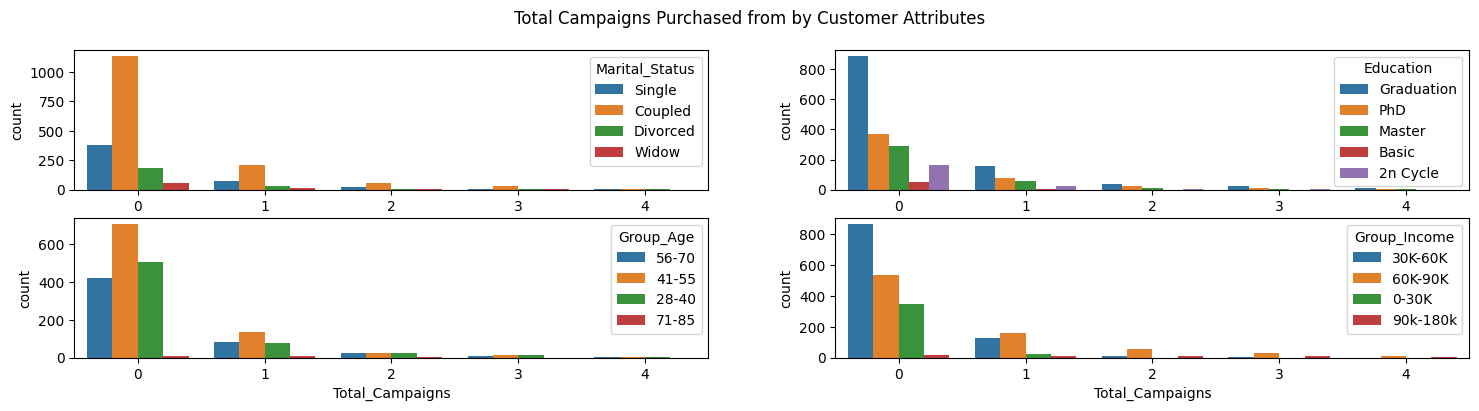

In [28]:
fig, axs = plt.subplots(2,2, figsize=(18,4))
sns.countplot(data=data_customer, hue='Marital_Status', x='Total_Campaigns', ax=axs[0,0])
sns.countplot(data=data_customer, hue='Education', x='Total_Campaigns', ax=axs[0,1])
sns.countplot(data=data_customer, hue='Group_Age', x='Total_Campaigns', ax=axs[1,0])
sns.countplot(data=data_customer, hue='Group_Income', x='Total_Campaigns', ax=axs[1,1])
plt.suptitle("Total Campaigns Purchased from by Customer Attributes")

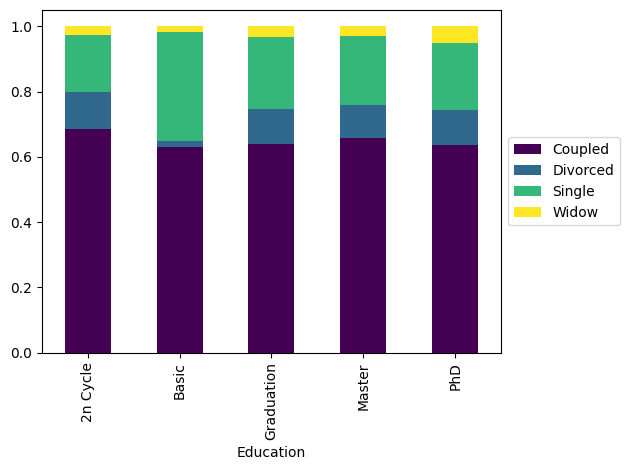

In [29]:
customer_plot = data_customer.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0)
customer_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, colormap='viridis')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

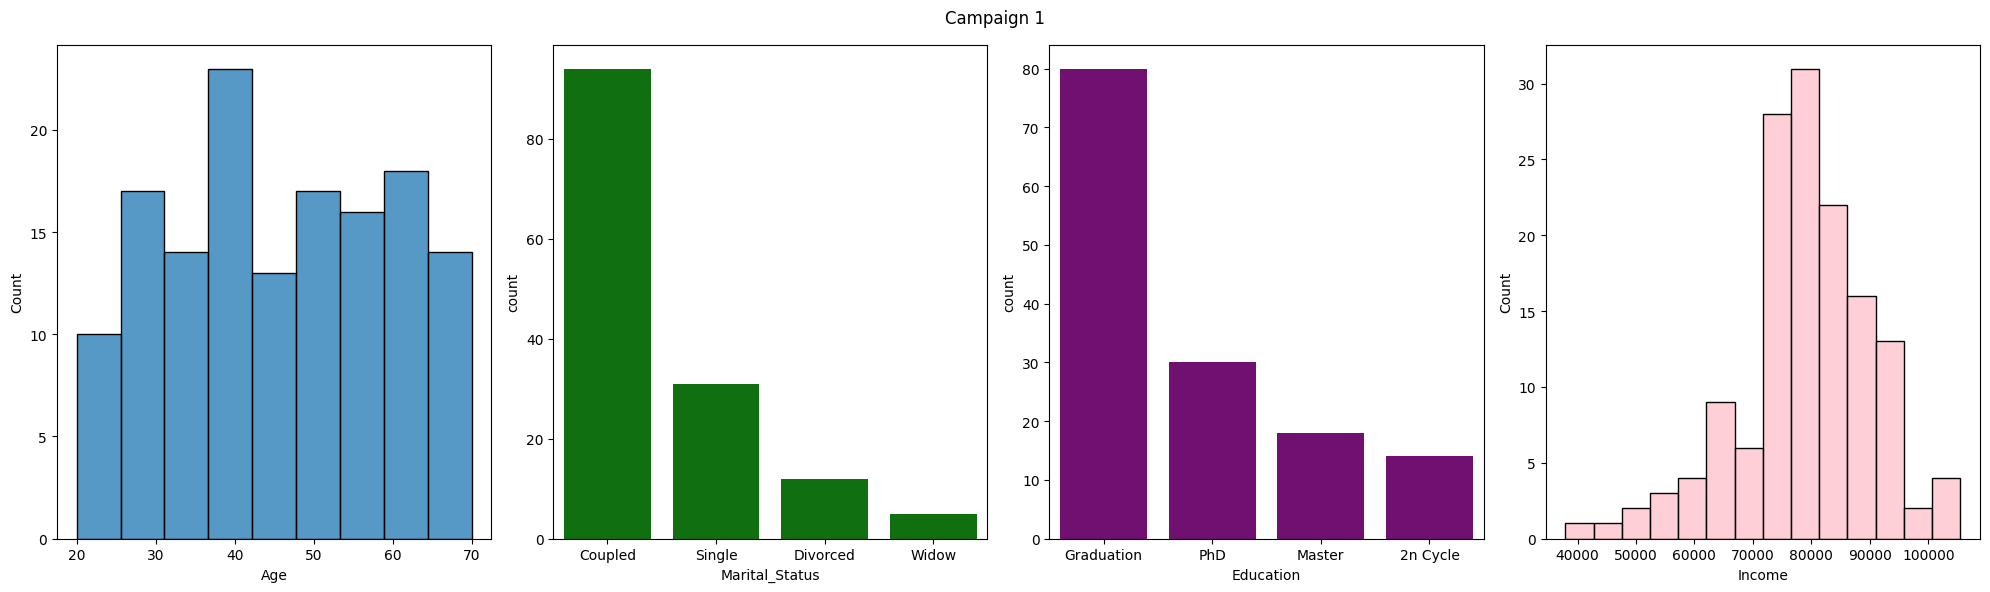

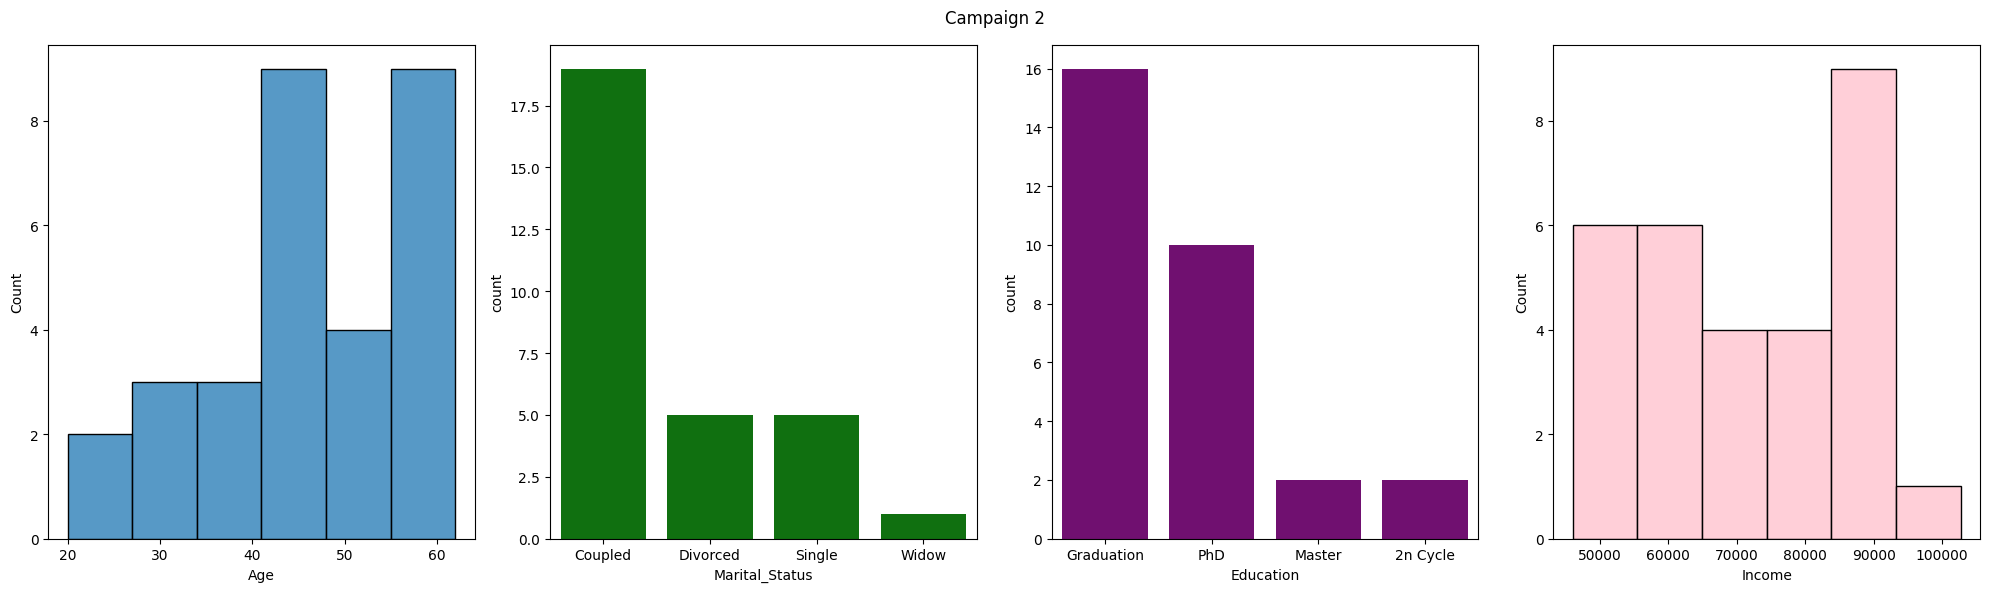

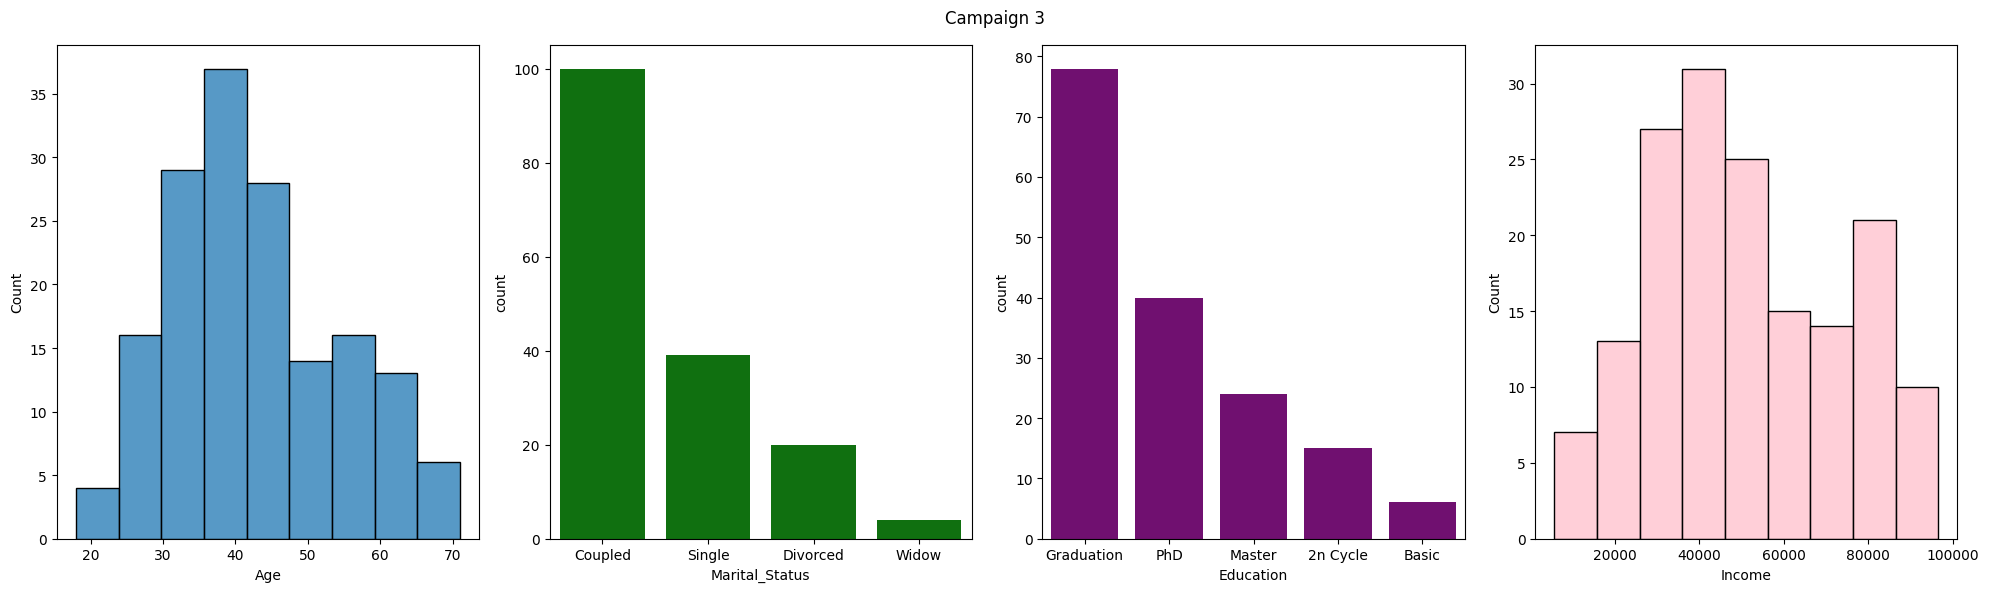

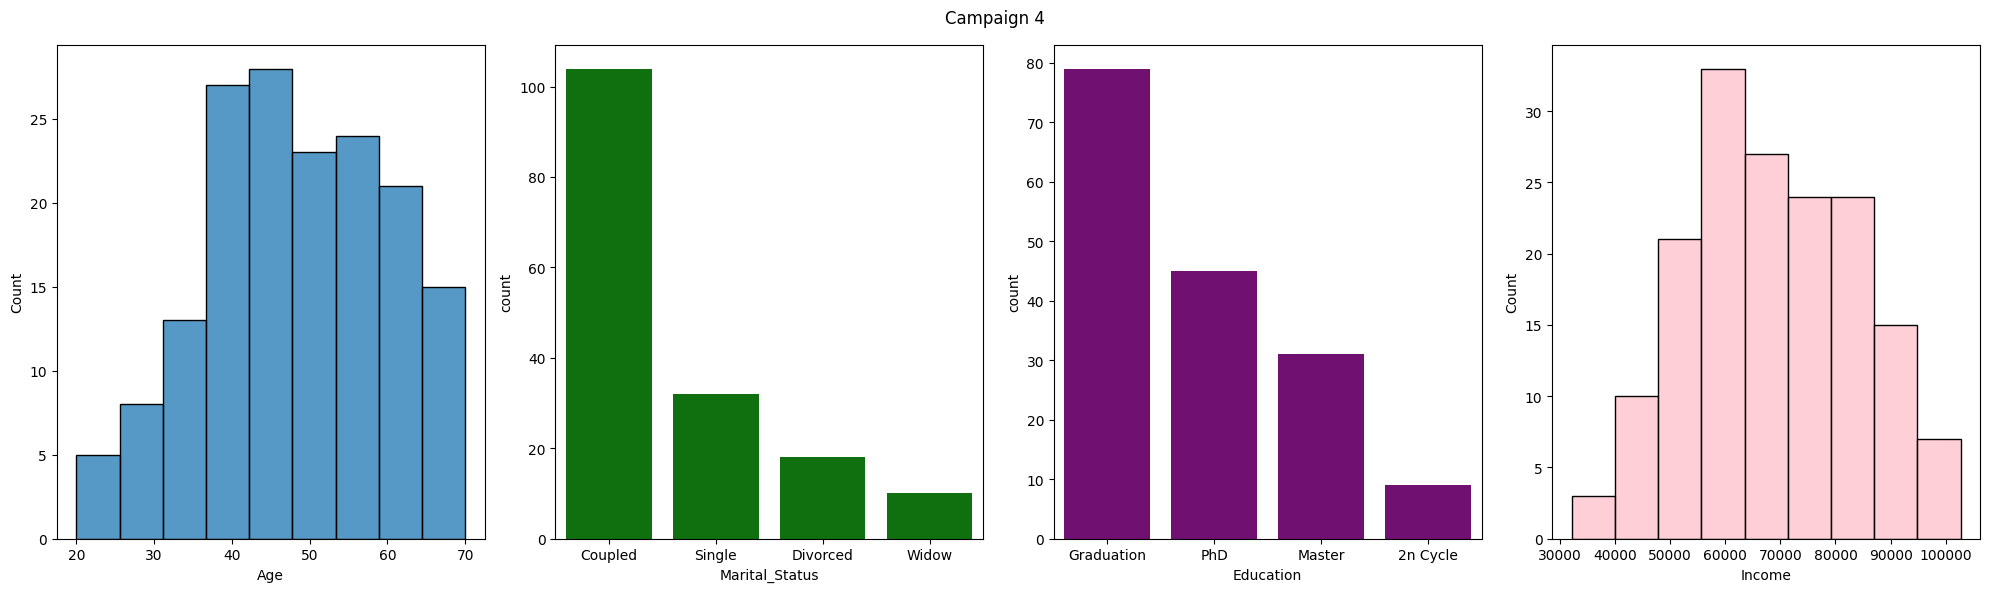

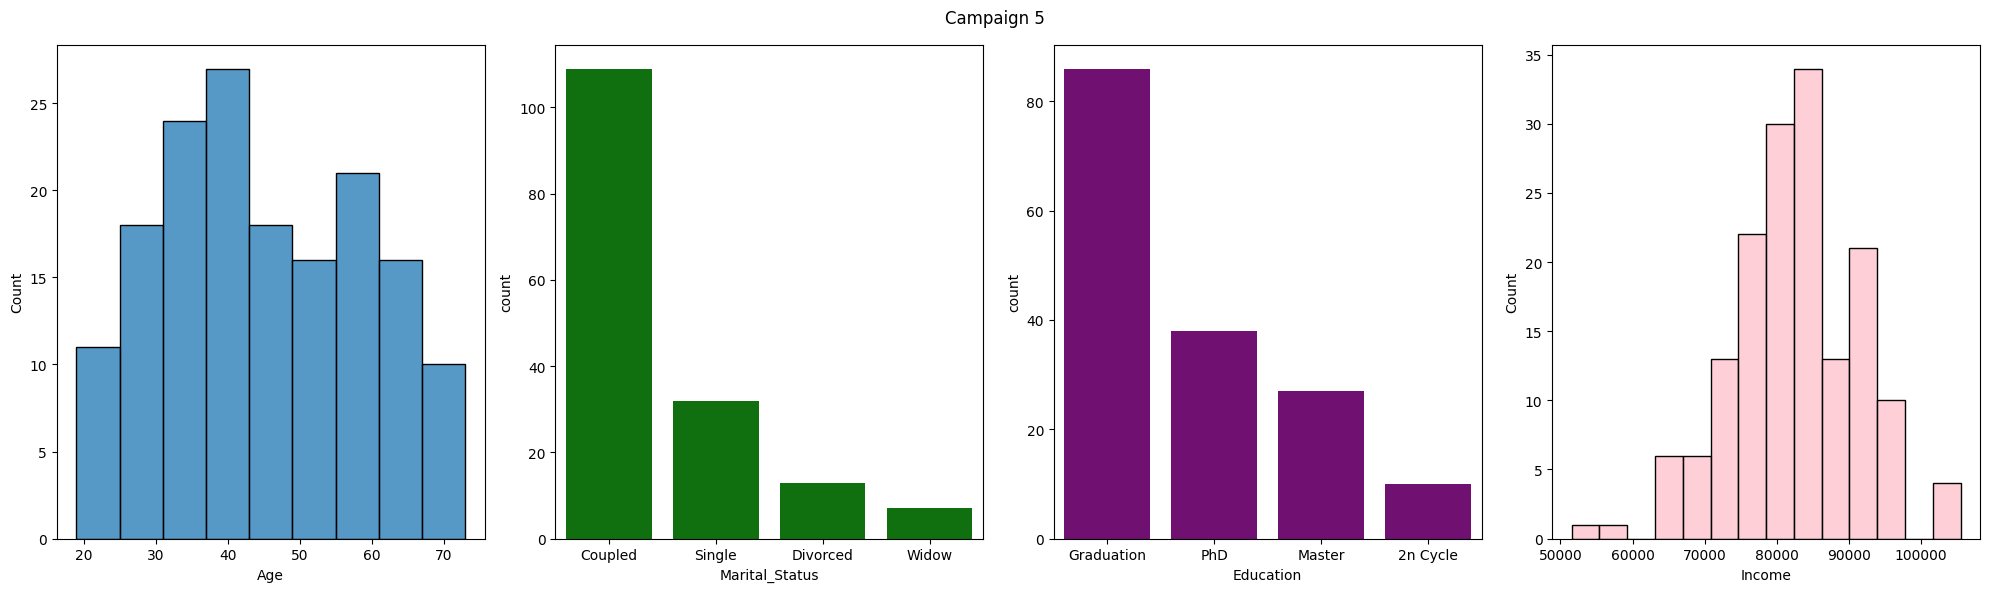

In [30]:
for col in campaign_columns:
    fig, axs = plt.subplots(1,4, figsize=(20,6))
    # Only consider rows where the campaign was True
    df_campaign = data[data[col]==True]

    sns.histplot(df_campaign['Age'], ax=axs[0])
    sns.barplot(df_campaign['Marital_Status'].value_counts(), color='green', ax=axs[1])
    sns.barplot(df_campaign['Education'].value_counts(), color='purple', ax=axs[2])
    # Create histogram
    sns.histplot(df_campaign['Income'], color='pink',ax=axs[3])
    fig.suptitle("Campaign " + col[-1])
    plt.tight_layout()
    plt.show()

### 4.0 Feature Engineering
- 4.1: Convert Categorical columns to numerical columns based on mapped values
- 4.2: Complete RFM (Recency-Frequency-Monetary) based on the amount of money spent on the 
- 4.3: Add features for proportions of sales based on different products

In [31]:
# 4.1 mapping categorical data to numerical values
# Map Marital Status to numerical values
data['Marital_Status'] = data['Marital_Status'].map({'Single': 1, 'Coupled': 2, 'Divorced':3, 'Widow':4}).astype(int)
# Map Education entries to numerical values
data['Education']=data['Education'].map({'Basic':0, '2n Cycle':1, 'Graduation':2, 'Master':3, 'PhD':4}).astype(int)
data['Education'].value_counts()

Education
2    1115
4     480
3     365
1     198
0      54
Name: count, dtype: int64

In [32]:
# Frequency and Monetary columns
# FREQUENCY (HOW MANY PURCHACES)
data["Frequency"] = data["NumDealsPurchases"] + data["NumWebPurchases"] + data["NumCatalogPurchases"] + data["NumStorePurchases"]
# MONETARY (CUSTOMER SPEND)
data["Monetary"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"] 

Text(0.5, 0.98, 'RFM Distributions')

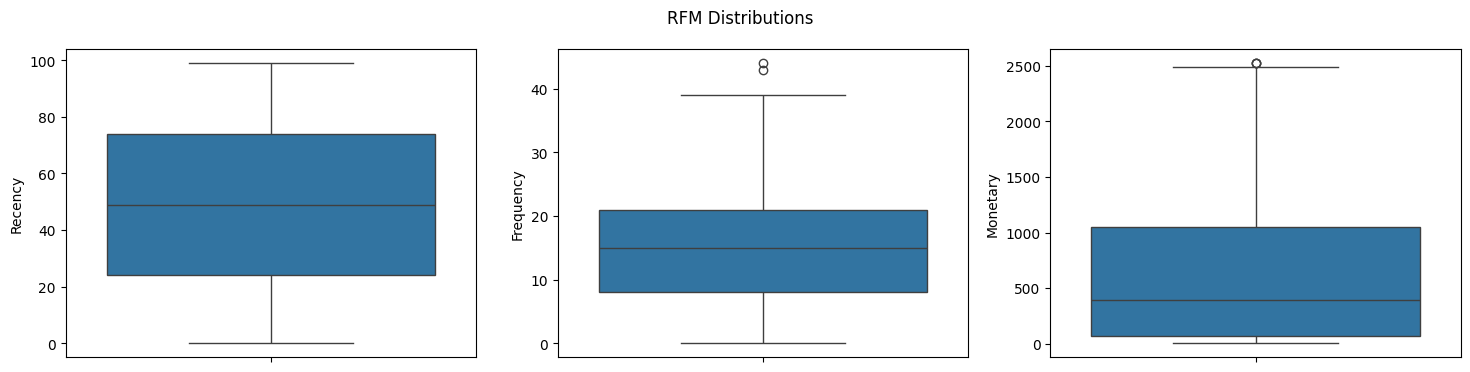

In [33]:
fig, axs = plt.subplots(1,3, figsize=(18,4))
sns.boxplot(data=data['Recency'], ax=axs[0])
sns.boxplot(data=data['Frequency'], ax=axs[1])
sns.boxplot(data=data['Monetary'], ax=axs[2])
plt.suptitle("RFM Distributions")

<Axes: >

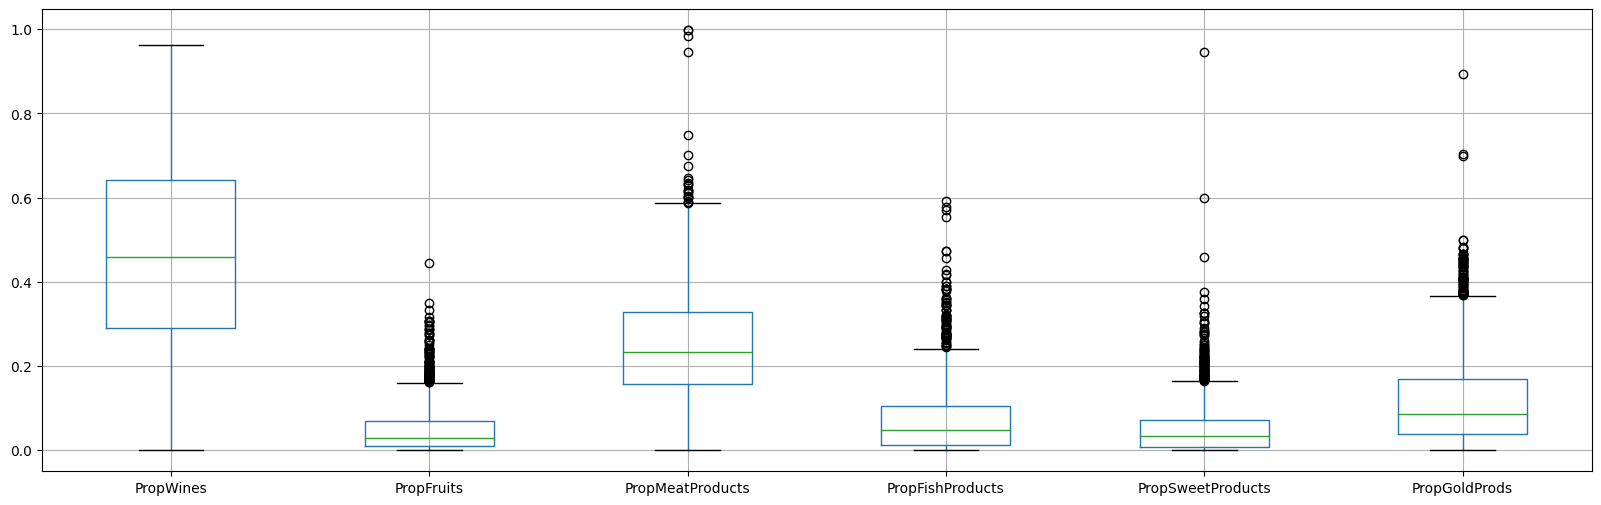

In [34]:
# Proportion of their total spend is spent on the various categories
data['PropWines'] = data["MntWines"]/data['Monetary']
data['PropFruits'] = data["MntFruits"]/data['Monetary']
data['PropMeatProducts'] = data["MntMeatProducts"]/data['Monetary']
data['PropFishProducts'] = data["MntFishProducts"]/data['Monetary']
data['PropSweetProducts'] = data["MntSweetProducts"]/data['Monetary']
data['PropGoldProds'] = data["MntGoldProds"]/data['Monetary']
data[['PropWines', 'PropFruits', 'PropMeatProducts', 'PropFishProducts', 'PropSweetProducts', 'PropGoldProds']].boxplot(figsize=(20,6))

## 4.0 INSIGHTS
- Most (75%) customers are repeat customers
- The majority (75%) of customers spend a total of under $1000 
- Customers purchased Wine more often.

In [35]:
data.to_pickle("data/marketing_dataset_cleaned.pkl")